<a id='top'></a>
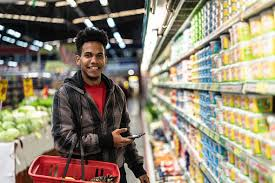

# Customer Supermarket Case Study

**Sorrenti Marco, Simone Baccile, Lorenzo Simone**

**Università di Pisa**

## Contents
1. [Clustering analysis](#clustering) 
    1. [K-means](#kmeans)
    2. [Density-based](#dbscan)
    3. [hierarchical clustering](#hierarchical)
    4. [X-Means](#xmeans)
    5. [G-Means](#gmeans)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

import kneed

from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.gmeans import gmeans

%matplotlib inline

In [2]:
df = pd.read_csv("data/customer_behaviour.csv", sep='\t', decimal=',')

In [3]:
df.head()

,CustomerID,Country,I,Iu,Imax,E1,E2,TotalCost,Mep,Lep,AvgUP,TotCart,AvgCart
0,17850.0,United Kingdom,1733,21,40,2.668814,0.811278,5391.21,35.75,1.06,3.960370,34,2.833333
1,13047.0,United Kingdom,1390,105,12,1.663235,0.000000,3232.59,12.75,0.42,3.926082,9,0.750000
2,12583.0,France,5028,114,12,0.000000,1.000000,6705.38,16.95,0.06,2.140474,15,1.250000
3,13748.0,United Kingdom,439,24,88,0.000000,0.468996,948.25,14.95,0.39,3.996429,5,0.416667
4,15100.0,United Kingdom,80,1,88,2.670152,1.000000,876.00,10.95,10.95,10.950000,3,0.250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5567 entries, 0 to 5566
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  5567 non-null   object 
 1   Country     5567 non-null   object 
 2   I           5567 non-null   int64  
 3   Iu          5567 non-null   int64  
 4   Imax        5567 non-null   int64  
 5   E1          5567 non-null   float64
 6   E2          5567 non-null   float64
 7   TotalCost   5567 non-null   float64
 8   Mep         5567 non-null   float64
 9   Lep         5567 non-null   float64
 10  AvgUP       5567 non-null   float64
 11  TotCart     5567 non-null   int64  
 12  AvgCart     5567 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage: 565.5+ KB


In [5]:
df.describe()

,I,Iu,Imax,E1,E2,TotalCost,Mep,Lep,AvgUP,TotCart,AvgCart
count,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000
mean,803.094485,57.585055,279.225795,0.932863,0.220306,1405.419366,15.007999,0.810251,3.456777,3.376325,0.281360
std,2328.855310,70.499399,475.233464,1.162966,0.375141,3542.508331,18.125290,1.369267,2.554577,5.290188,0.440849
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.390000,0.060000,0.040000,0.060000,1.000000,0.083333
25%,106.000000,13.000000,72.000000,0.000000,0.000000,223.015000,7.950000,0.290000,2.207366,1.000000,0.083333
50%,278.000000,32.000000,150.000000,0.227257,0.000000,576.260000,12.750000,0.420000,3.010851,2.000000,0.166667
75%,760.500000,77.000000,296.000000,1.627554,0.503258,1384.550000,16.950000,0.850000,4.160111,4.000000,0.333333
max,63312.000000,884.000000,6760.000000,6.966608,1.000000,68370.090000,195.000000,21.950000,74.975000,97.000000,8.083333


<a id='clustering'></a>
## 1. Clustering analysis ([to top](#top))

#### Normalization of values using the StandardScaler

In [6]:
columns = ['I', 'Iu', 'Imax', 'E1', 'E2', 'TotalCost', 'Mep', 'Lep', 'AvgUP', 'TotCart', 'AvgCart']

In [7]:
X = StandardScaler().fit_transform(df[columns].values)

<a id='kmeans'></a>
### 1.A K-means based clustering ([to top](#top))
Analysis by k-means based clustering:

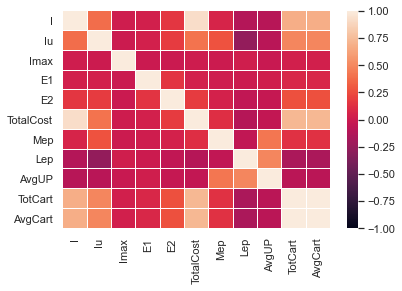

In [8]:
np.random.seed(0)

sns.set_theme()

corr_matrix = df[columns].corr()

plt.figure()
plot = sns.heatmap(corr_matrix, linewidths= 0.005,  vmax=1.0, vmin= -1.0)
sns.set_style("whitegrid")
plt.show()

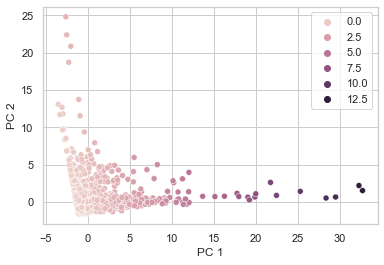

In [9]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
principalnp = principalDf.values

PCA_min, PCA_max = np.min(principalnp[:,0]+principalnp[:,1]), np.max(principalnp[:,0]+principalnp[:,1])
hue = np.around(((principalnp[:,0]*14+principalnp[:,1]*3)-PCA_min)/(PCA_max-PCA_min), decimals=1)
sc = sns.scatterplot(data=principalDf, x="PC1", y="PC2", hue = hue)
sc.set(xlabel='PC 1', ylabel='PC 2')
sns.set_style("whitegrid")
plt.show()

(11, 5567)


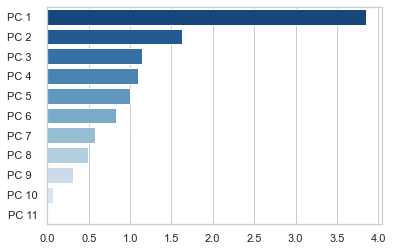

In [10]:
pca = PCA(n_components=11)
pca = pca.fit_transform(X)
print(pca.T.shape)

VAR = [np.var(pca[:,i]) for i in range(pca.shape[1])]
ax = sns.barplot( x =VAR,y=["PC "+str(i+1) if i>8 else "PC "+str(i+1)+"  "  for i in range(len(VAR))], palette="Blues_r")
sns.set_style("whitegrid")
plt.show()

In [11]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
    }

sse = []
silhouette_coefficients = []
max_k = 21
for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    if(k>1):
      sil_score = silhouette_score(X, kmeans.labels_)
      silhouette_coefficients.append(sil_score)


In [12]:
kl = kneed.KneeLocator(range(1, len(sse)+1), sse, curve="convex", direction="decreasing")
n_clusters = kl.elbow
print(n_clusters)

8


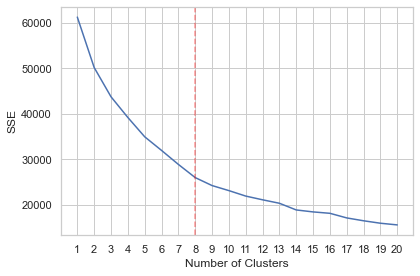

In [13]:
plt.figure(tight_layout=True)
plt.plot(range(1, max_k), sse)
plt.xticks(range(1, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.axvline(x = 8, color='red',linestyle='--', alpha=0.4)
sns.set_style("whitegrid")
plt.show()

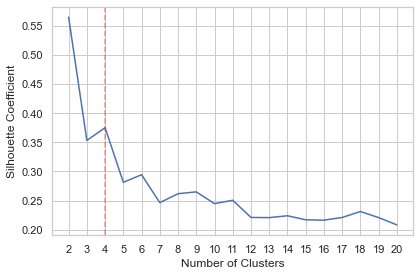

In [14]:
plt.figure(tight_layout=True)
plt.plot(range(2, max_k), silhouette_coefficients)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
sns.set_style("whitegrid")
plt.axvline(x = 4, color='red',linestyle='--', alpha=0.4)
plt.show()

(4, 3)


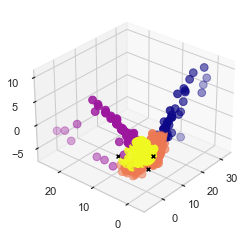

<Figure size 432x288 with 0 Axes>

In [15]:
kmeans = KMeans(
   init="random",
   n_clusters=4,
   n_init=10,
   max_iter=300,
   random_state=42
   )

kmeans.fit(X)

y_kmeans = kmeans.predict(X)

pca_pipeline = PCA(n_components=3)
pca = pca_pipeline.fit_transform(X)

centers = kmeans.cluster_centers_
centers = pca_pipeline.fit_transform(centers)

print(centers.shape)

fig = plt.figure()
plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0], pca[:, 1],pca[:, 2], c=y_kmeans, cmap='plasma', s=60)


for i in range(centers.shape[0]):
  ax.scatter(centers[i, 0], centers[i, 1],centers[i, 2], c='black', cmap='magma',marker = 'x', s=15)

sns.set_style("whitegrid")
ax.view_init(30, 220)
plt.show()



<a id='dbscan'></a>
### 1.B Density-based ([to top](#top))
Analysis by density-based clustering:

#### Analysis of the property values for eps and minPts
We want find the best value of eps and minPts for the DBSCAN algorithm. We proceed as follow:
* **eps**: find the best value using NN algorithm, then compare it with iterative algorithm that fixed minPts to number of feature*2 (formula given by literature) find the best eps value using Silhouette and Separation score.
* **minPts**: find the best value using the formula number of feature*2, then compare it with iterative algorithm that fixed eps given by NN find the best minPts value using Silhouette and Separation score.

#### eps

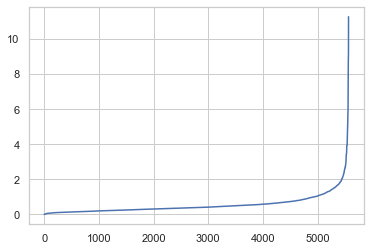

In [16]:
neighbors = NearestNeighbors(n_neighbors=11)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [17]:
kl = kneed.KneeLocator(range(1, len(distances)+1), distances, curve="convex", direction="increasing")
best_eps = kl.elbow
print(best_eps, distances[best_eps])
eps = distances[best_eps]

5496 2.575161853843742


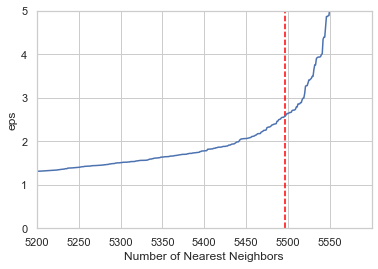

In [18]:
plt.axis([5200,5600,0,5])
plt.xticks(range(5200, 5600, 50))
plt.xlabel("Number of Nearest Neighbors")
plt.ylabel("eps")
plt.axvline(x=best_eps, color='red', linestyle='--', alpha=1)
plt.plot(distances)
#plt.savefig('Plot/nn_dbscan.png', bbox_inches = "tight")

Compare this value with fixed minPts

In [19]:
sil = []
sep = []
for i in (np.arange(2, 3, 0.05).tolist()):
        dbscan = DBSCAN(eps=i, min_samples=22)
        dbscan.fit(X)
        sil.append((i, silhouette_score(X, dbscan.labels_)))
        sep.append((i, davies_bouldin_score(X, dbscan.labels_)))

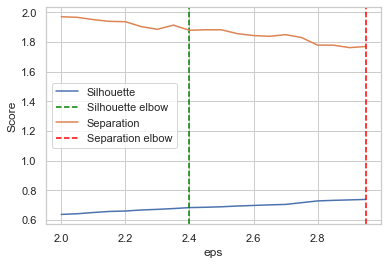

In [20]:
# Silhouette Score
x_val_sil = [x[0] for x in sil]
y_val_sil = [x[1] for x in sil]
plt.plot(x_val_sil, y_val_sil, label='Silhouette')
kl_sil = kneed.KneeLocator(x_val_sil, y_val_sil, curve="concave", direction="increasing")
plt.axvline(x=kl_sil.elbow, color='green', linestyle='--', alpha=1, label='Silhouette elbow')

# Separation Score
x_val_sep = [x[0] for x in sep]
y_val_sep = [x[1] for x in sep]
plt.plot(x_val_sep, y_val_sep, label='Separation')
kl_sep = kneed.KneeLocator(x_val_sep, y_val_sep, curve="concave", direction="decreasing")
plt.axvline(x=kl_sep.elbow, color='red', linestyle='--', alpha=1, label='Separation elbow')

plt.xlabel('eps')
plt.ylabel('Score')
plt.legend()
#plt.savefig('Plot/eps_score_dbscan.png', bbox_inches = "tight")
plt.show()

#### minPts

In [21]:
sil = []
sep = []
for i in (np.arange(5, 30, 2).tolist()):
        dbscan = DBSCAN(eps=eps, min_samples=i)
        dbscan.fit(X)
        sil.append((i, silhouette_score(X, dbscan.labels_)))
        sep.append((i, davies_bouldin_score(X, dbscan.labels_)))

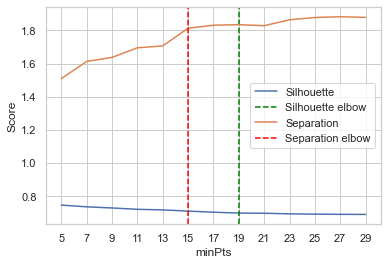

In [22]:
# Silhouette Score
x_val_sil = [x[0] for x in sil]
y_val_sil = [x[1] for x in sil]
plt.plot(x_val_sil, y_val_sil, label='Silhouette')
kl_sil = kneed.KneeLocator(x_val_sil, y_val_sil, curve="convex", direction="decreasing")
plt.axvline(x=kl_sil.elbow, color='green', linestyle='--', alpha=1, label='Silhouette elbow')

# Separation Score
x_val_sep = [x[0] for x in sep]
y_val_sep = [x[1] for x in sep]
plt.plot(x_val_sep, y_val_sep, label='Separation')
kl_sep = kneed.KneeLocator(x_val_sep, y_val_sep, curve="concave", direction="increasing")
plt.axvline(x=kl_sep.elbow, color='red', linestyle='--', alpha=1, label='Separation elbow')
plt.xticks(range(5, 30, 2))

plt.xlabel('minPts')
plt.ylabel('Score')
plt.legend()
#plt.savefig('Plot/minpts_score_dbscan.png', bbox_inches = "tight")
plt.show()

In [23]:
minPts=17

#### DBSCAN algorithm

In [24]:
dbscan = DBSCAN(eps=eps, min_samples=minPts)
dbscan.fit(X)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([ 168, 5399]))

Exploration of mandatory features after DBSCAN.

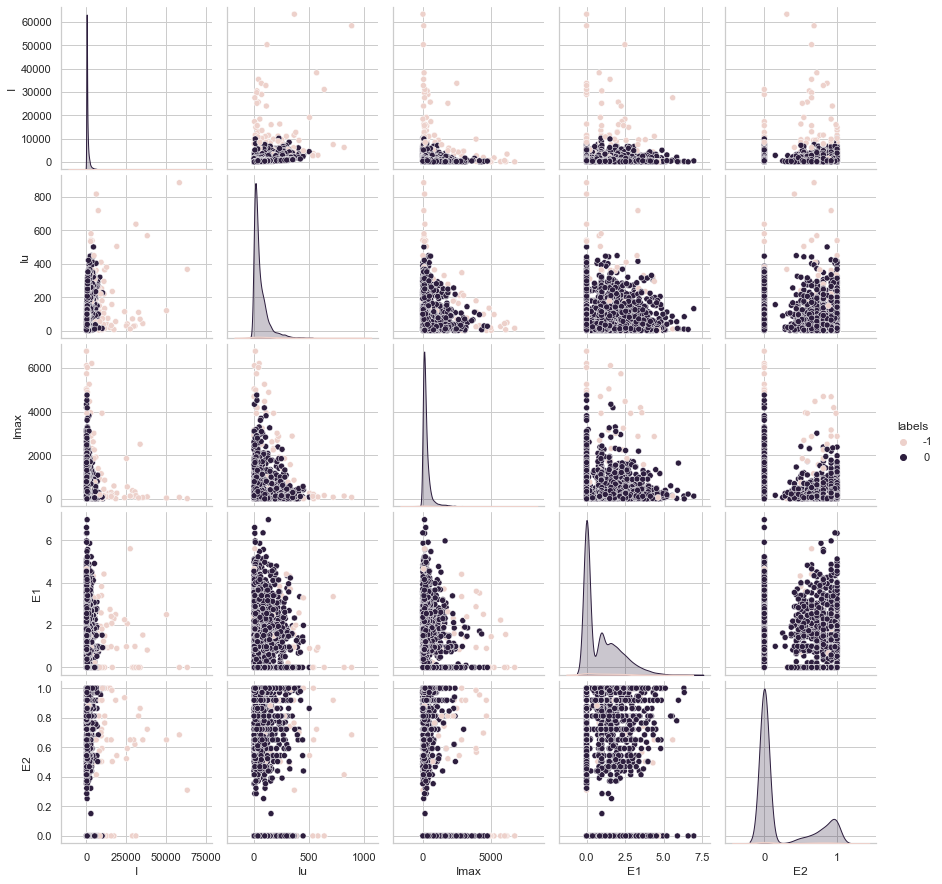

In [25]:
tmp = pd.DataFrame(dbscan.labels_)
tmp = pd.concat((df[columns], tmp), axis=1)
tmp = tmp.rename({0:'labels'}, axis=1)
sns.pairplot(tmp[['I', 'Iu', 'Imax', 'E1', 'E2', 'labels']], hue='labels')
#plt.savefig('Plot/dbscan_plot.png', bbox_inches = "tight")

In [26]:
print('Final Evaluation:')
print('Silhouette Score: {}'.format(silhouette_score(X, dbscan.labels_)))
print('Separation Score: {}'.format(davies_bouldin_score(X, dbscan.labels_)))

Final Evaluation:
Silhouette Score: 0.7041321445262577
Separation Score: 1.8309480755067702


<a id='hierarchical'></a>
### 1.C Hierarchical clustering ([to top](#top))
Analysis by hierarchical clustering

##### Clustering Preprocessing - Normalization  
The most common adopted normalizations are: Z-Score and Min-Max.

In [27]:
pca = PCA(n_components=3)
X1 = pca.fit_transform(X)

In [28]:
pca.explained_variance_ratio_

array([0.3502509 , 0.14764168, 0.10378   ])

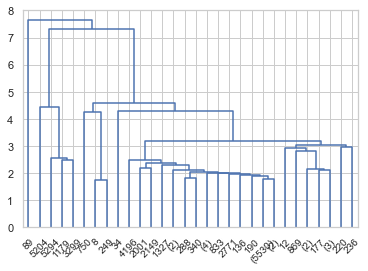

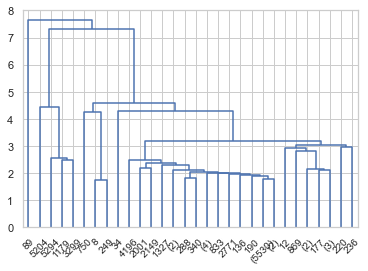

In [29]:
data_dist = pdist(X1, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
plt.gcf()

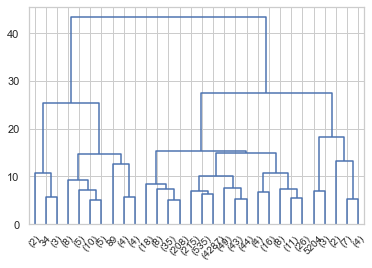

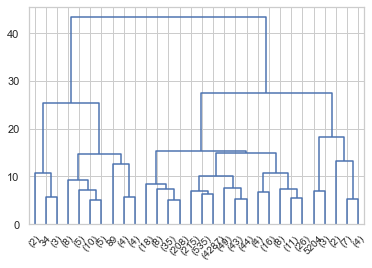

In [30]:
data_dist = pdist(X1, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')
plt.gcf()

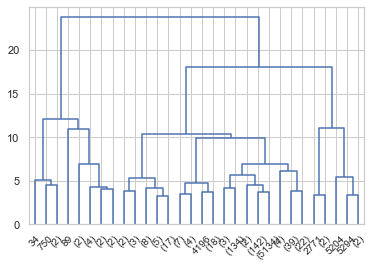

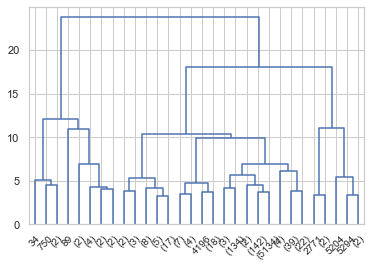

In [31]:
data_dist = pdist(X1, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')
plt.gcf()

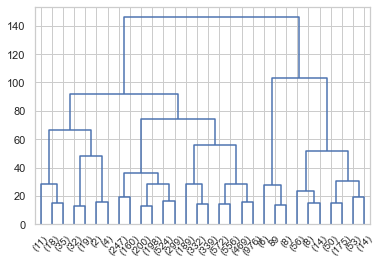

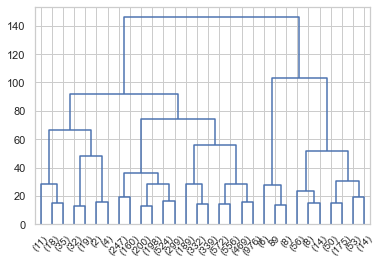

In [32]:
data_dist = pdist(X1, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
plt.gcf()

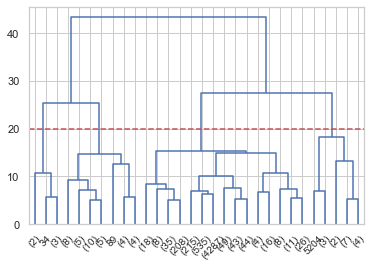

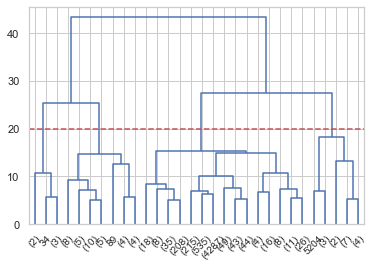

In [33]:
data_dist = pdist(X1, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')
plt.axhline(y=20, color='r', linestyle='--')
plt.gcf()

In [34]:
hcluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
hcp=hcluster.fit_predict(X1)
print('Silhouette Score for Hieararchial Clustering: '+str(silhouette_score(X,hcp,metric='euclidean')))

Silhouette Score for Hieararchial Clustering: 0.7598663005229623


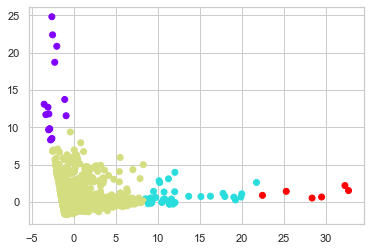

In [35]:
plt.scatter(X1[:,0],X1[:,1], c=hcluster.labels_, cmap='rainbow')

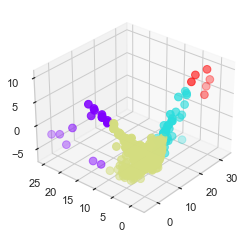

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:,0], X1[:,1], X1[:,2], c=hcluster.labels_,cmap='rainbow', s=60)
ax.view_init(30, 220)
plt.gcf()
plt.show()

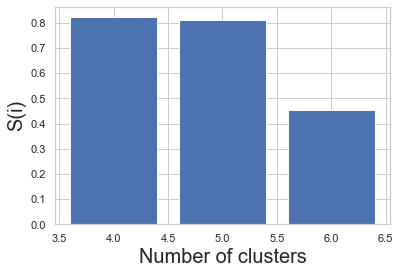

In [37]:
ac4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
ac5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
ac6 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')


k = [4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 

silhouette_scores.append(silhouette_score(X1, ac4.fit_predict(X1))) 
silhouette_scores.append(silhouette_score(X1, ac5.fit_predict(X1))) 
silhouette_scores.append(silhouette_score(X1, ac6.fit_predict(X1))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20)
plt.gcf()
plt.show() 

<a id='xmeans'></a>
### 1.D X-Means ([to top](#top))
Analysis by X-Means clustering:

In [38]:
pca = PCA(n_components=3)
X1 = pca.fit_transform(X)
sample = X1.tolist()

In [39]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()

In [40]:
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 4.
xmeans_instance = xmeans(sample, initial_centers, 4)
xmeans_instance.process()

In [41]:
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

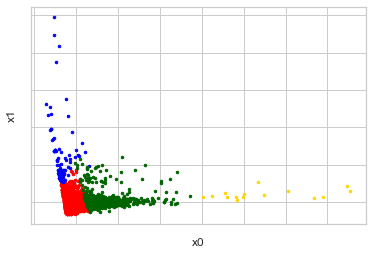

In [42]:
# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample)
visualizer.show(pair_filter=[[0, 1]])

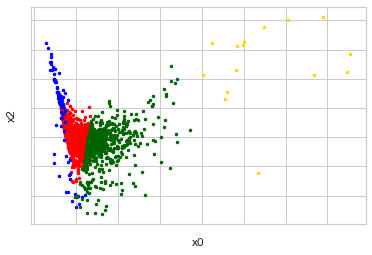

In [43]:
visualizer.show(pair_filter=[[0, 2]])

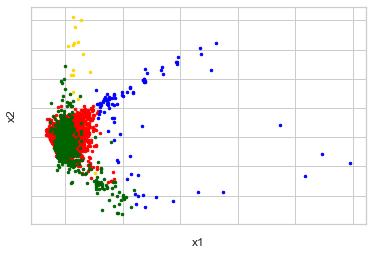

In [44]:
visualizer.show(pair_filter=[[1, 2]])

<a id='gmeans'></a>
### 1.E G-Means ([to top](#top))
Analysis by G-Means clustering

In [45]:
# Create instance of G-Means algorithm.
gmeans_instance = gmeans(sample, repeat=5)
gmeans_instance.process()

In [46]:
# Extract clustering results: clusters and their centers
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()

In [47]:
len(clusters)

215

In [48]:
# Print total sum of metric errors
print("Total WCE:", gmeans_instance.get_total_wce())

Total WCE: 1307.2023167308791


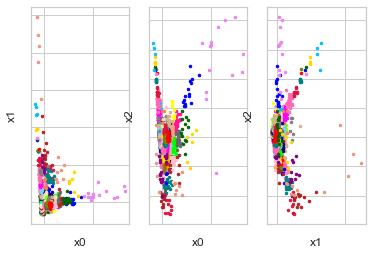

In [49]:
# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample)
visualizer.show(pair_filter=[[0, 1], [0, 2], [1,2]])